<a href="https://colab.research.google.com/github/ChristianMocha/PrediccionVideoJuegos/blob/master/PrediccionVideoJuegos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
# Matplotlib visualización
import matplotlib.pyplot as plt
# Seaborn para visualización
import seaborn as sns
import calendar
from datetime import datetime
from pandas import Series
from math import ceil

#Leer y explorar datos

In [ ]:
df = pd.read_csv('../content/Video_Games_Sales_as_at_22_Dec_2016.csv', encoding="utf-8")
dfa = df
dfa = dfa.copy()
df[:5]

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


#Valores superiores en el conjunto de datos
Por plataforma, desarrollador, editor y género.

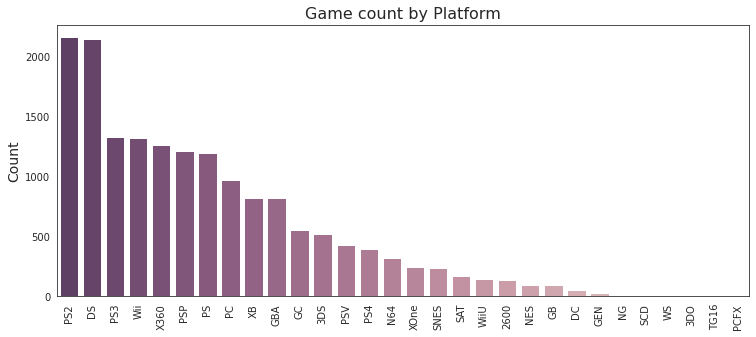

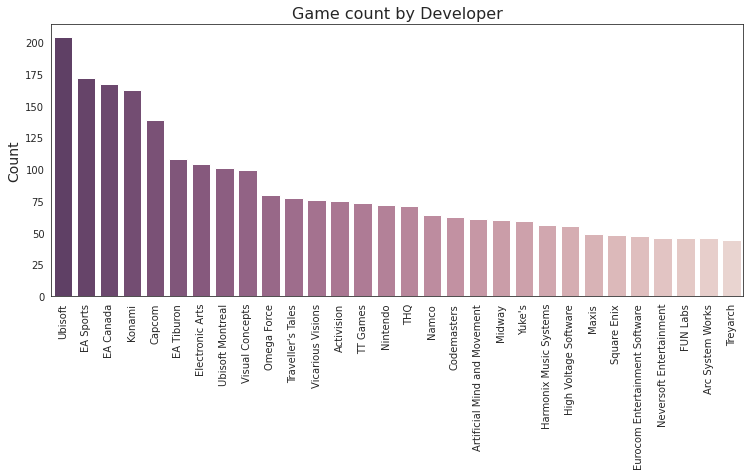

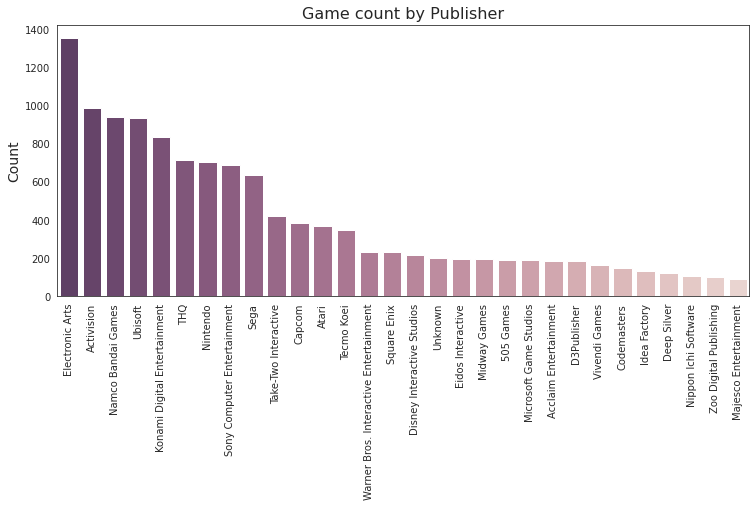

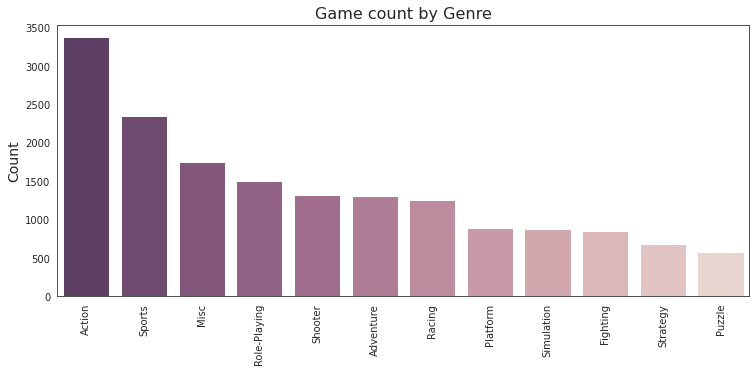

In [ ]:
cols = ['Platform', 'Developer', 'Publisher', 'Genre']

for col in cols:
    chart = df[['Name', col]].groupby([col]).count().sort_values('Name', ascending=False).reset_index()
    sns.set_style("white")
    plt.figure(figsize=(12.4, 5))
    plt.xticks(rotation=90)
    sns.barplot(x=col, y='Name', data=chart[:30], palette=sns.cubehelix_palette((12 if col == 'Genre' else 30), dark=0.3, light=.85, reverse=True)).set_title(('Game count by '+col), fontsize=16)
    plt.ylabel('Count', fontsize=14)
    plt.xlabel('')

#Ventas vs puntajes críticos
Por plataforma, desarrollador, editor y género.

In [ ]:
def score_group(score):
    if score >= 90:
        return '90-100'
    elif score >= 80:
        return '80-89'
    elif score >= 70:
        return '70-79'
    elif score >= 60:
        return '60-69'
    elif score >= 50:
        return '50-59'
    else:
        return '0-49'

In [ ]:
dfh = df.dropna(subset=['Critic_Score']).reset_index(drop=True)
dfh['Score_Group'] = dfh['Critic_Score'].apply(lambda x: score_group(x))

In [ ]:
def in_top(x):
    if x in pack:
        return x
    else:
        pass
def width(x):
    if x == 'Platform':
        return 14.4
    elif x == 'Developer':
        return 13.2
    elif x == 'Publisher':
        return 11.3
    elif x == 'Genre':
        return 13.6

def height(x):
    if x == 'Genre':
        return 8
    else:
        return 9

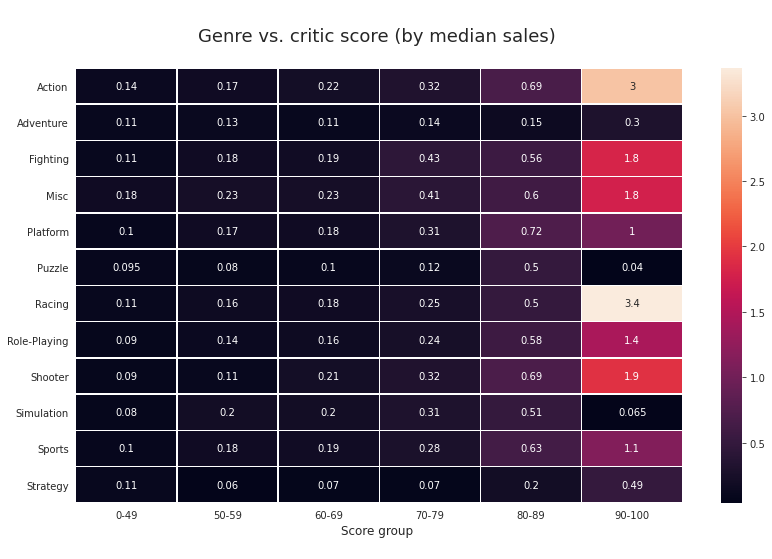

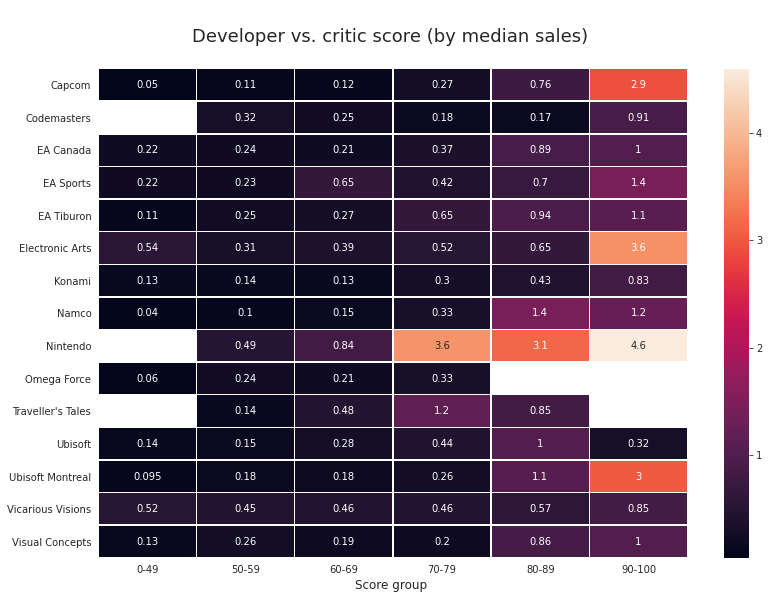

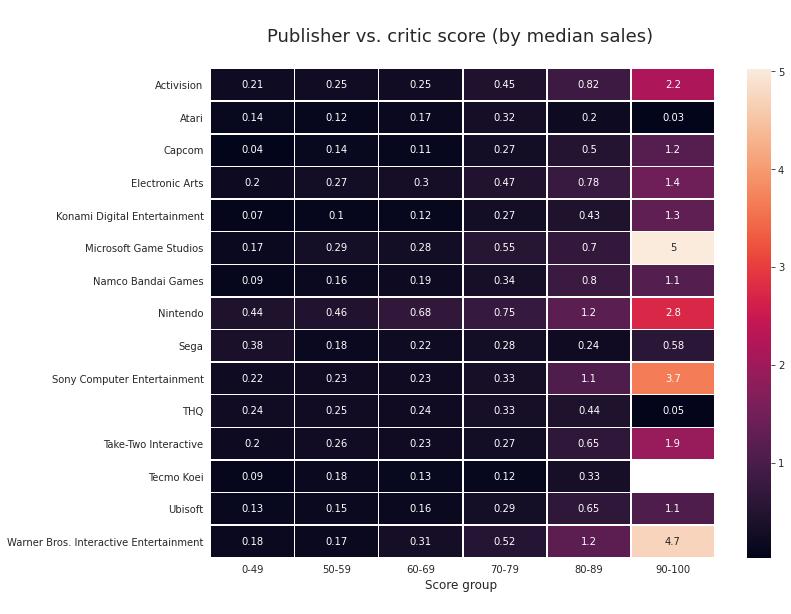

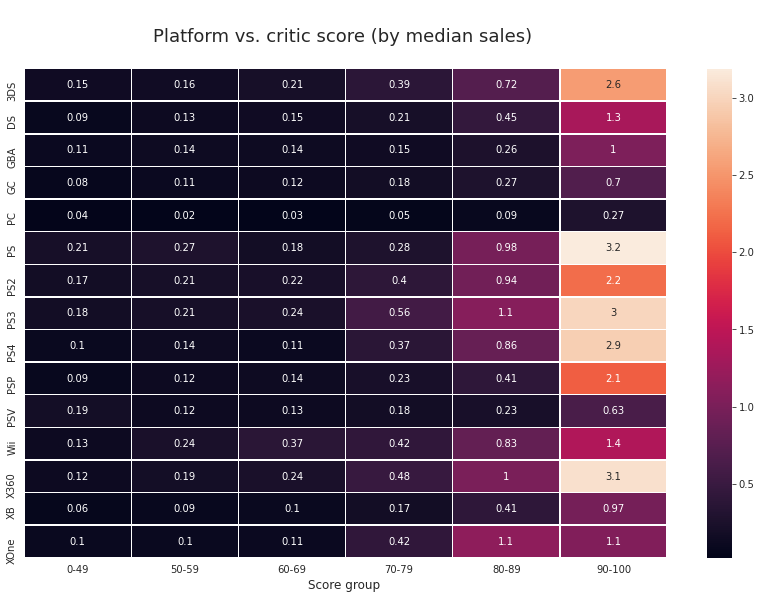

In [ ]:
cols = ['Genre', 'Developer', 'Publisher', 'Platform']
for col in cols:
    pack = []
    top = dfh[['Name', col]].groupby([col]).count().sort_values('Name', ascending=False).reset_index()[:15]
    for x in top[col]:
        pack.append(x)
    dfh[col] = dfh[col].apply(lambda x: in_top(x))
    dfh_platform = dfh[[col, 'Score_Group', 'Global_Sales']].groupby([col, 'Score_Group']).median().reset_index().pivot(col, "Score_Group", "Global_Sales")
    plt.figure(figsize=(width(col), height(col)))
    sns.heatmap(dfh_platform, annot=True, fmt=".2g", linewidths=.5).set_title((' \n'+col+' vs. critic score (by median sales) \n'), fontsize=18)
    plt.ylabel('', fontsize=14)
    plt.xlabel('Score group \n', fontsize=12)
    pack = []

#Correlaciones de conjunto de datos

Conversión de columnas categóricas en códigos numéricos.

In [ ]:
cols = ['Platform', 'Genre', 'Publisher', 'Developer', 'Rating']
for col in cols:
    uniques = df[col].value_counts().keys()
    uniques_dict = {}
    ct = 0
    for i in uniques:
        uniques_dict[i] = ct
        ct += 1

    for k, v in uniques_dict.items():
        df.loc[df[col] == k, col] = v

In [ ]:
df1 = df[['Platform','Genre','Publisher','Year_of_Release','Critic_Score','Global_Sales']]
df1 = df1.dropna().reset_index(drop=True)
df1 = df1.astype('float64')

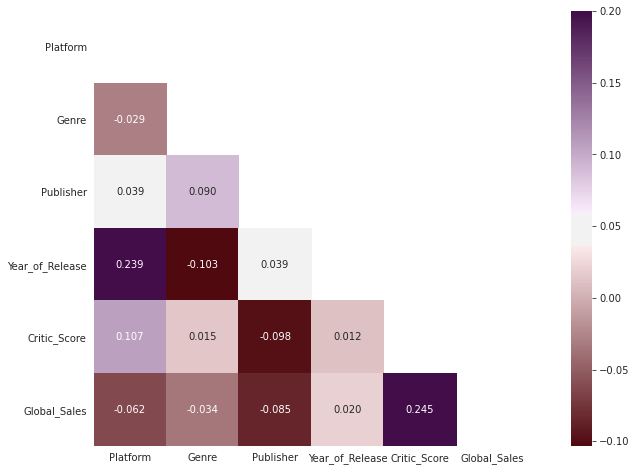

In [ ]:
mask = np.zeros_like(df1.corr())
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(730, 300, sep=20, as_cmap=True, s=85, l=15, n=20) # note: 680, 350/470
with sns.axes_style("white"):
    fig, ax = plt.subplots(1,1, figsize=(15,8))
    ax = sns.heatmap(df1.corr(), mask=mask, vmax=0.2, square=True, annot=True, fmt=".3f", cmap=cmap)

Las correlaciones más fuertes son:

- Puntajes críticos en ventas globales: veremos más de cerca esto a continuación.

- Año de lanzamiento a la plataforma: Esto tiene sentido ya que periódicamente salen nuevas plataformas.

Puntajes críticos para ventas globales

[(0.0, 17.5)]

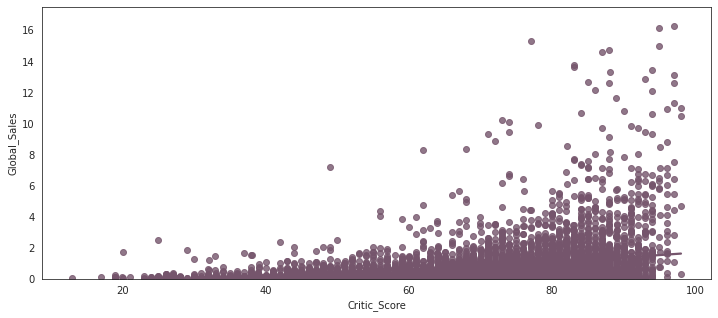

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(12,5))
sns.regplot(x="Critic_Score", y="Global_Sales", data=df1, ci=None, color="#75556c", x_jitter=.02).set(ylim=(0, 17.5))

[(0.0, 4.0), (50.0, 95.0)]

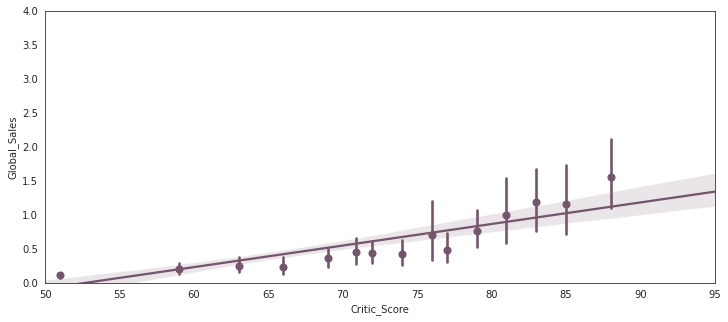

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(12,5))
sns.regplot(x="Critic_Score", y="Global_Sales", data=df1.loc[df1.Year_of_Release >= 2014],
            truncate=True, x_bins=15, color="#75556c").set(ylim=(0, 4), xlim=(50, 95))

La relación se ve mucho más clara ahora. Es interesante cómo la pendiente se vuelve más empinada en los años 80. Parece que una vez que un juego obtiene un alto puntaje crítico, cada punto adicional tiene un mayor impacto. Hazlo en grande o vete a casa, correcto?

Parece que los puntajes críticos serán una buena característica para el modelo de predicción en la sección 2.

Definiendo éxitos como aquellos con ventas superiores a 1 millón de unidades
Este será el objetivo en nuestro modelo de predicción, donde pronosticaremos si un juego será un éxito o no.

In [ ]:
dfb = dfa[['Name','Platform','Genre','Publisher','Year_of_Release','Critic_Score','Global_Sales']]
dfb = dfb.dropna().reset_index(drop=True)
df2 = dfb[['Platform','Genre','Publisher','Year_of_Release','Critic_Score','Global_Sales']]
df2['Hit'] = df2['Global_Sales']
df2.drop('Global_Sales', axis=1, inplace=True)

In [ ]:
def hit(sales):
    if sales >= 1:
        return 1
    else:
        return 0

df2['Hit'] = df2['Hit'].apply(lambda x: hit(x))

Grafiquemos la relación entre los puntajes críticos y los golpes de VG usando una muestra del 5% ...

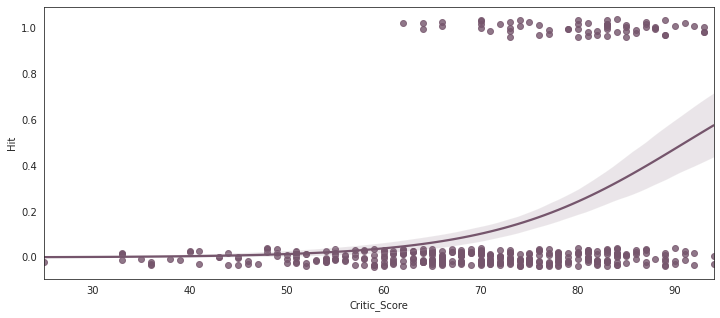

In [ ]:
# Gráfico de regresión logística con muestra de datos
n = ceil(0.05 * len(df2['Hit']))
fig, ax = plt.subplots(1,1, figsize=(12,5))
sns.regplot(x="Critic_Score", y="Hit", data=df2.sample(n=n),
            logistic=True, n_boot=500, y_jitter=.04, color="#75556c")

Como se esperaba, parece que los éxitos se encuentran principalmente cerca de puntajes críticos altos, mientras que los no hits pueden variar en puntajes, pero no tienen una presencia tan fuerte en los rangos de puntajes altos (como se ve en la curva de regresión empinada cerca de los años 70).

#2. Modelo de predicción
Para predecir VG con ventas de unidades de 1 millón o más (visitas).

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix

#Generando características

In [ ]:
df2[:5]

,Platform,Genre,Publisher,Year_of_Release,Critic_Score,Hit
0,Wii,Sports,Nintendo,2006.0,76.0,1
1,Wii,Racing,Nintendo,2008.0,82.0,1
2,Wii,Sports,Nintendo,2009.0,80.0,1
3,DS,Platform,Nintendo,2006.0,89.0,1
4,Wii,Misc,Nintendo,2006.0,58.0,1


In [ ]:
from pandas import get_dummies
df_copy = pd.get_dummies(df2)

In [ ]:
df_copy[:5]

,Year_of_Release,Critic_Score,Hit,Platform_3DS,Platform_DC,Platform_DS,Platform_GBA,Platform_GC,Platform_PC,Platform_PS,Platform_PS2,Platform_PS3,Platform_PS4,Platform_PSP,Platform_PSV,Platform_Wii,Platform_WiiU,Platform_X360,Platform_XB,Platform_XOne,Genre_Action,Genre_Adventure,Genre_Fighting,Genre_Misc,Genre_Platform,Genre_Puzzle,Genre_Racing,Genre_Role-Playing,Genre_Shooter,Genre_Simulation,Genre_Sports,Genre_Strategy,Publisher_10TACLE Studios,Publisher_1C Company,Publisher_2D Boy,Publisher_3DO,Publisher_505 Games,Publisher_5pb,Publisher_AQ Interactive,Publisher_ASCII Entertainment,...,Publisher_Telegames,Publisher_Telltale Games,Publisher_Tetris Online,Publisher_The Adventure Company,Publisher_Titus,Publisher_Tomy Corporation,Publisher_Touchstone,Publisher_Trion Worlds,Publisher_Tripwire Interactive,Publisher_Tru Blu Entertainment,Publisher_UFO Interactive,Publisher_Ubisoft,Publisher_Ubisoft Annecy,Publisher_Universal Interactive,Publisher_Unknown,Publisher_Valcon Games,Publisher_Valve,Publisher_Valve Software,Publisher_Vatical Entertainment,Publisher_Victor Interactive,Publisher_Vir2L Studios,Publisher_Virgin Interactive,Publisher_Visco,Publisher_Vivendi Games,Publisher_Wanadoo,Publisher_Wargaming.net,Publisher_Warner Bros. Interactive Entertainment,Publisher_White Park Bay Software,Publisher_XS Games,Publisher_Xicat Interactive,Publisher_Xplosiv,Publisher_Xseed Games,Publisher_Yacht Club Games,Publisher_Yuke's,Publisher_Zoo Digital Publishing,Publisher_Zoo Games,Publisher_Zushi Games,Publisher_bitComposer Games,Publisher_id Software,Publisher_inXile Entertainment
0,2006.0,76.0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2008.0,82.0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2009.0,80.0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2006.0,89.0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2006.0,58.0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
df3 = df_copy
y = df3['Hit'].values
df3 = df3.drop(['Hit'],axis=1)
X = df3.values

In [ ]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.50, random_state=2)


# Prueba de precisión de predicción con LR,RFC y SVM 

In [ ]:
from time import time
start_time = time()
radm = RandomForestClassifier(random_state=2).fit(Xtrain, ytrain)

y_val_1 = radm.predict(Xtest)
val = print("Validation accuracy: ", sum(pd.DataFrame(y_val_1).idxmax(axis=1).values
                                   == ytest)/len(ytest))

from sklearn.metrics import zero_one_loss
error_rate_svm = zero_one_loss(ytest,y_val_1)
error_rate_svm=str(round(error_rate_svm, 4))
print("Error rate (%): ",error_rate_svm)
elapsed_time = time() - start_time
print("Tiempo de ejecución (s): ", elapsed_time)

Validation accuracy:  0.8271109997494362
Error rate (%):  0.1351
Tiempo de ejecución (s):  1.262796401977539


In [ ]:
from time import time
start_time1 = time()
log_reg = LogisticRegression().fit(Xtrain, ytrain)

y_val_2 = log_reg.predict(Xtest)

val1 = print("Validation accuracy: ", sum(pd.DataFrame(y_val_2).idxmax(axis=1).values
                                   == ytest)/len(ytest))

from sklearn.metrics import zero_one_loss
error_rate_svm = zero_one_loss(ytest,y_val_2)
error_rate_svm=str(round(error_rate_svm, 4))
print("Error rate (%): ",error_rate_svm)
elapsed_time1 = time() - start_time1
print("Tiempo de ejecución (s): ",elapsed_time1)

Validation accuracy:  0.8271109997494362
Error rate (%):  0.1356
Tiempo de ejecución (s):  0.4329991340637207


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
from sklearn.svm import SVC
classifier = SVC(gamma="auto", kernel='poly', C=0.1, random_state = 0, verbose=True)
from time import time
start_time2 = time()
classifier.fit(Xtrain,ytrain)

#Predicciones del conjunto de Test

y_pred = classifier.predict(Xtest)
model_acc = classifier.score(Xtest, ytest)
test_acc_svm = accuracy_score(ytest, y_pred) #accuracy_score hace lo mismo que la función score 
acc_svm=str(round(test_acc_svm, 4))
print('\nSVM Accuracy con classifier.score: ', str(round(model_acc, 4)))
val2 = print('\nSVM Accuracy con accuracy_score: ', acc_svm)

from sklearn.metrics import zero_one_loss
error_rate_svm = zero_one_loss(ytest,y_pred)
error_rate_svm=str(round(error_rate_svm, 4))
print("Error rate (%): ",error_rate_svm)
elapsed_time2 = time() - start_time2
print("Tiempo de ejecución (s): ",elapsed_time2)

[LibSVM]
SVM Accuracy con classifier.score:  0.8619

SVM Accuracy con accuracy_score:  0.8619
Error rate (%):  0.1381
Tiempo de ejecución (s):  9.499783039093018


In [ ]:
all_predictions = log_reg.predict(Xtest)
print(classification_report(ytest, all_predictions))

              precision    recall  f1-score   support

           0       0.88      0.97      0.92      3301
           1       0.73      0.34      0.47       690

    accuracy                           0.86      3991
   macro avg       0.80      0.66      0.69      3991
weighted avg       0.85      0.86      0.84      3991



In [ ]:
all_predictions1 = radm.predict(Xtest)
print(classification_report(ytest, all_predictions1))

              precision    recall  f1-score   support

           0       0.89      0.96      0.92      3301
           1       0.68      0.41      0.51       690

    accuracy                           0.86      3991
   macro avg       0.78      0.69      0.72      3991
weighted avg       0.85      0.86      0.85      3991



In [ ]:
all_predictions2 = classifier.predict(Xtest)
print(classification_report(ytest, all_predictions2))

              precision    recall  f1-score   support

           0       0.88      0.97      0.92      3301
           1       0.71      0.34      0.46       690

    accuracy                           0.86      3991
   macro avg       0.79      0.65      0.69      3991
weighted avg       0.85      0.86      0.84      3991



In [ ]:
from math import *
from numpy import * 
#X = [val , val1 , acc_svm]
#plt(X)
#y = [1 , 2 , 3]
#plt.hist(X,y)

#plt.show()

[Text(10.5, 0.5, 'Expected Value'), Text(0.5, 1.5, 'Predicted Value')]

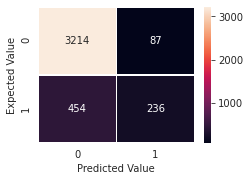

In [ ]:
fig, ax = plt.subplots(figsize=(3.5,2.5))
sns.heatmap(confusion_matrix(ytest, all_predictions), annot=True, linewidths=.5, ax=ax, fmt="d").set(xlabel='Predicted Value', ylabel='Expected Value')

# Clasificación de rendimiento de la función

In [ ]:
indices = np.argsort(radm.feature_importances_)[::-1]

# Print the feature ranking
print('Feature ranking (top 10):')

for f in range(10):
    print('%d. feature %d %s (%f)' % (f+1 , indices[f], df3.columns[indices[f]],
                                      radm.feature_importances_[indices[f]]))

Feature ranking (top 10):
1. feature 1 Critic_Score (0.326461)
2. feature 0 Year_of_Release (0.166946)
3. feature 216 Publisher_Nintendo (0.027233)
4. feature 19 Genre_Action (0.021519)
5. feature 99 Publisher_Electronic Arts (0.019508)
6. feature 27 Genre_Shooter (0.019204)
7. feature 42 Publisher_Activision (0.017003)
8. feature 29 Genre_Sports (0.016701)
9. feature 9 Platform_PS2 (0.014028)
10. feature 10 Platform_PS3 (0.014002)


# ¿Qué juegos de 2016 aún pueden convertirse en éxitos?

In [ ]:
not_hit_copy = df_copy[df_copy['Hit'] == 0]

In [ ]:
df4 = not_hit_copy
y = df4['Hit'].values
df4 = df4.drop(['Hit'],axis=1)
X = df4.values

In [ ]:
pred = classifier.predict(X)

In [ ]:
dfb = dfb[dfb['Global_Sales'] < 1]

In [ ]:
dfb['Hit_Probability'] = pred[:,1]

In [42]:
dfb = dfb[dfb['Year_of_Release'] == 2016]
dfb.sort_values(['Hit_Probability'], ascending=[False], inplace=True)
dfb = dfb[['Name', 'Platform', 'Hit_Probability']]

KeyError: ignored

# Los 10 mejores juegos de 2016 con la mayor probabilidad de convertirse en éxitos:

In [ ]:
dfb[:10].reset_index(drop=True)

,Name,Platform,Genre,Publisher,Year_of_Release,Critic_Score,Global_Sales
0,EA Sports UFC 2,PS4,Sports,Electronic Arts,2016.0,79.0,0.93
1,Kirby: Planet Robobot,3DS,Action,Nintendo,2016.0,81.0,0.93
2,Street Fighter V,PS4,Fighting,Capcom,2016.0,77.0,0.90
3,Far Cry: Primal,XOne,Action,Ubisoft,2016.0,77.0,0.88
4,Titanfall 2,PS4,Shooter,Electronic Arts,2016.0,89.0,0.75
5,LEGO Marvel's Avengers,PS4,Action,Warner Bros. Interactive Entertainment,2016.0,71.0,0.73
6,Dragon Ball: Xenoverse 2,PS4,Action,Namco Bandai Games,2016.0,73.0,0.71
7,Lego Star Wars: The Force Awakens,PS4,Action,Warner Bros. Interactive Entertainment,2016.0,78.0,0.70
8,Farming Simulator 17,PC,Simulation,Focus Home Interactive,2016.0,64.0,0.65
9,Dishonored 2,PS4,Action,Bethesda Softworks,2016.0,88.0,0.64


# Los 10 mejores juegos de 2016 con la menor probabilidad de convertirse en éxitos:

In [ ]:
dfb[:-11:-1].reset_index(drop=True)

,Name,Platform,Genre,Publisher,Year_of_Release,Critic_Score,Global_Sales
0,Prison Architect,XOne,Action,Introversion Software,2016.0,74.0,0.01
1,Fast Racing Neo,WiiU,Action,Nintendo,2016.0,81.0,0.01
2,Sébastien Loeb Rally Evo,XOne,Racing,Milestone S.r.l,2016.0,63.0,0.01
3,Carmageddon: Max Damage,PS4,Action,Stainless Games,2016.0,51.0,0.01
4,Dungeons 2,PS4,Role-Playing,Kalypso Media,2016.0,61.0,0.01
5,Ride 2,PC,Racing,Milestone S.r.l,2016.0,78.0,0.01
6,Root Letter,PS4,Adventure,PQube,2016.0,69.0,0.01
7,Sherlock Holmes: The Devil's Daughter,PS4,Adventure,Bigben Interactive,2016.0,70.0,0.01
8,Super Dungeon Bros,PS4,Action,Nordic Games,2016.0,42.0,0.01
9,TrackMania Turbo,PC,Action,Ubisoft,2016.0,79.0,0.01
